**Procedure**

Cleaned and standardized raw water-quality data; converted all parameters to numeric form and imputed missing values using the median.

Computed WQI using the weighted arithmetic index method with standard limits and weights.

Performed exploratory and correlation analysis to verify data consistency.

Validated the pipeline using linear and regularized regression (deterministic WQI recovery).

Evaluated nonlinear models and addressed extreme WQI behavior via residual and band-wise error analysis.

Fine-tuned a Gradient Boosting Regressor and selected it as the final model based on cross-validated MAE and stability.

In [26]:
import numpy as np
import pandas as pd


In [27]:

df = pd.read_csv("/content/WQI Parameter 2016-18 Narmada - Sheet2.csv")
print(df.shape)

print("--"* 50)

df.head()

(731, 9)
----------------------------------------------------------------------------------------------------


,Temperature,Turbidity,pH,T. Solids,Nitrate Nitrogen,Phosphate (PO4),D. Oxygen,B.O.D.,F. Coliform
0,26.4,2.7,7.41,176.0,0.40,NaN,7.7,1.2,1.0
1,34,3.4,7.61,178.0,0.22,NaN,7.7,1.4,1.0
2,26.8,3.2,7.62,187.0,0.40,NaN,7.5,1.1,2.0
3,26.2,3.2,7.80,212.0,0.64,NaN,7.5,1.7,8.0
4,28.6,6.4,7.71,196.0,0.60,0.2,7.5,1.4,7.0


In [28]:
#Initial Inspection of the data
print(df.info())
print("--"*50)
print(df.describe())
print("--"*50)
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        456 non-null    object 
 1   Turbidity          707 non-null    object 
 2   pH                 731 non-null    float64
 3   T.  Solids         724 non-null    float64
 4   Nitrate  Nitrogen  657 non-null    float64
 5   Phosphate (PO4)    649 non-null    object 
 6   D.  Oxygen         730 non-null    float64
 7   B.O.D.             723 non-null    float64
 8   F.  Coliform       502 non-null    float64
dtypes: float64(6), object(3)
memory usage: 51.5+ KB
None
----------------------------------------------------------------------------------------------------
               pH  T.  Solids  Nitrate  Nitrogen  D.  Oxygen      B.O.D.  \
count  731.000000  724.000000         657.000000  730.000000  723.000000   
mean     8.042562  252.038253           0.907763    9.116

In [29]:
df["Temperature"].unique()


array(['26.4', '34', '26.8', '26.2', '28.6', '29', '27.4', '24', '20.4',
       '19.5', '22.5', '20.5', '28.5', '36', '27.6', '29.4', '28.2',
       '23.5', '25', '22.8', '23.6', nan, '28', '23', '19 ºC', '21 ºC',
       '26', '18', '20ºC', '20 ºC', '19', '24ºC', '27', '20', '22',
       '23 ºC', '21', '30', '24.5', '31', '31.4', '32.5', '31.5', '29.5',
       '25.4', '20.9', '19.1', '17.8', '30.2', '25.8', '24.8', '21.3',
       '19.6', '22.4', '1', '30.5', '28.8', '26.7', '21.4', '3', '21.9',
       '24.97603687'], dtype=object)

In [30]:
# Clean Temperature column
df["Temperature"] = (
    df["Temperature"]
    .astype(str)
    .str.replace("ºC", "", regex=False)
    .str.replace("°C", "", regex=False)
    .str.replace("C", "", regex=False)
    .str.strip()
)

df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")


In [31]:
df["Temperature"].unique()

array([26.4       , 34.        , 26.8       , 26.2       , 28.6       ,
       29.        , 27.4       , 24.        , 20.4       , 19.5       ,
       22.5       , 20.5       , 28.5       , 36.        , 27.6       ,
       29.4       , 28.2       , 23.5       , 25.        , 22.8       ,
       23.6       ,         nan, 28.        , 23.        , 19.        ,
       21.        , 26.        , 18.        , 20.        , 27.        ,
       22.        , 30.        , 24.5       , 31.        , 31.4       ,
       32.5       , 31.5       , 29.5       , 25.4       , 20.9       ,
       19.1       , 17.8       , 30.2       , 25.8       , 24.8       ,
       21.3       , 19.6       , 22.4       ,  1.        , 30.5       ,
       28.8       , 26.7       , 21.4       ,  3.        , 21.9       ,
       24.97603687])

In [32]:
df["Temperature"].dtype


dtype('float64')

In [33]:
df["Turbidity"].unique()


array(['2.7', '3.4', '3.2', '6.4', '2.8', '3.8', '1.8', '2', '2.2', '1.7',
       '22', '6.2', '3.6', '5.4', '4.8', '1.9', '1.6', '3.1', '4.6',
       '8.2', '24', '6.6', '6', '5.2', '2.6', '1', '8', '15', '1.5', '3',
       nan, '10', '12', '3.5', '4', '5', '4.3', '0.2', '4.2', '0.1',
       '2.3', '34', '32', '-', '5.6', '0.9', '1.3', '3.7', '10.5', '10.6',
       '7.7', '12.5', '36', '16', '8.8', '30', '8.4', '1.4', '1.94',
       '4.5', '1.1', '0.8', '0.6', '1.2', '7.2', '0.4', '14', '3.3',
       '2.4', '2.5', '2.1', '6.1', '6.8', '1.41', '1.02', '1.08', '14.6',
       '1.21', '5.1', '0.82', '2.01', '7.1', '6.42', '6.3', '8.9', '8.02',
       '5.7', '12.1', '7.01', '4.9', '0.7', '2.9', '8.5', '5.8', '7.9',
       '5.9', '8.6', '3.9', '7', 'g', '2.16', '4.15', '9.5', '1.68',
       '0.81', '0.5', '34.8', '26', '0.64', '0.86', '0.44', '175', '74',
       '0.67', '134', '72', '0.021', '0.58', '0.68', '38.6', '0.89',
       '0.76', '40.9', '43.4', '7.4', '0.84', '1.06', '3.41', '10.8'

In [34]:
# Clean Turbidity column
df["Turbidity"] = (
    df["Turbidity"]
    .astype(str)
    .str.replace(" ", "", regex=False)
    .replace({"-": np.nan, "g": np.nan})
)

# Convert to numeric
df["Turbidity"] = pd.to_numeric(df["Turbidity"], errors="coerce")


In [35]:
df["Turbidity"].dtype

dtype('float64')

In [36]:
df["Phosphate (PO4)"].unique()


array([nan, '0.2', '0.24', '0.04', '0.12', '0.1', '0.014', '0.012',
       '0.024', 'ND', '0.4', '0.14', '0.16', '0.01', '0.02', '0.26',
       '0.64', '0.44', '0.22', '0.28', '0.18', '0.033', '0.132', '0.112',
       '0.25', '0.6', '0.165', '0.5', '0.11', '0.23', '1', '5.23', '2',
       '7.6', '0.8', '0.34', '0.35', '0.05', '0.054', '0.057', '0.55',
       '0.3', '1.01', '-', '0.495', '0.48', '0.023', '0.03', '7.7', '7.2',
       '0.726', '0.561', '0.099', '0.56', '0.462', '0.396', '0.15',
       '0.49', '0.07', '0', '0.06', '0.75', '0.013', '0.015', '0.429',
       '0.33', '2.2', '2.1', '2.4', '1.9', '1.8', '22', '0.66', '0.031',
       '0.028', '1.03', '0.008', '0.0161', '0.006', '0.011', '0.019',
       '0.018', '0.009', '0.016', '0.026', '0.021', '0.036', '0.007',
       '0.029', '0.039', '0.032', '0.022', '0.001', '0.003', '0.017',
       '0.062', 'Trace', 'BOL', 'BDE', '0.42', '6', '0.62', '0.41', '15',
       'l l2', '1.2', '0.i', '0.038', 'BDT', '0.7', 'O.1', '1.4', '0.D23',


In [37]:
#cleaning the Phosphate column
df["Phosphate (PO4)"] = (
    df["Phosphate (PO4)"]
    .astype(str)
    .str.lower()
    .str.strip()
)


invalid_markers = [
    "nd", "trace", "-", "bdl", "b dl", "bdt", "bde", "bol",
    "8dl", "8dc", "bdl", "b dl"
]

df["Phosphate (PO4)"] = df["Phosphate (PO4)"].replace(invalid_markers, np.nan)


df["Phosphate (PO4)"] = (
    df["Phosphate (PO4)"]
    .str.replace(" ", "", regex=False)
    .str.replace("o.", "0.", regex=False)
    .str.replace("o0", "0.0", regex=False)
)


df["Phosphate (PO4)"] = pd.to_numeric(df["Phosphate (PO4)"], errors="coerce")


In [38]:
df["Phosphate (PO4)"].dtype

dtype('float64')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        456 non-null    float64
 1   Turbidity          673 non-null    float64
 2   pH                 731 non-null    float64
 3   T.  Solids         724 non-null    float64
 4   Nitrate  Nitrogen  657 non-null    float64
 5   Phosphate (PO4)    594 non-null    float64
 6   D.  Oxygen         730 non-null    float64
 7   B.O.D.             723 non-null    float64
 8   F.  Coliform       502 non-null    float64
dtypes: float64(9)
memory usage: 51.5 KB


In [40]:
df = df.rename(columns={
    "Temperature": "temperature",
    "Turbidity": "turbidity",
    "pH": "ph",
    "T.  Solids": "total_solids",
    "Nitrate  Nitrogen": "nitrate_nitrogen",
    "Phosphate (PO4)": "phosphate_po4",
    "D.  Oxygen": "dissolved_oxygen",
    "B.O.D.": "bod",
    "F.  Coliform": "fecal_coliform"
})


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       456 non-null    float64
 1   turbidity         673 non-null    float64
 2   ph                731 non-null    float64
 3   total_solids      724 non-null    float64
 4   nitrate_nitrogen  657 non-null    float64
 5   phosphate_po4     594 non-null    float64
 6   dissolved_oxygen  730 non-null    float64
 7   bod               723 non-null    float64
 8   fecal_coliform    502 non-null    float64
dtypes: float64(9)
memory usage: 51.5 KB


All the columns have been standarized by the name and converted into the numeric format

**Missing value imputation**

In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

df_imputed = pd.DataFrame(
    imputer.fit_transform(df),
    columns=df.columns
)


In [44]:
df_imputed.isna().sum()

,0
temperature,0
turbidity,0
ph,0
total_solids,0
nitrate_nitrogen,0
phosphate_po4,0
dissolved_oxygen,0
bod,0
fecal_coliform,0


**Exploratory Sanity Checks (Pre-WQI Readiness)**

In [45]:
df_imputed.describe().T


,count,mean,std,min,25%,50%,75%,max
temperature,731.0,24.482320,3.191461,1.000,23.000,24.000,25.40,36.00
turbidity,731.0,5.658180,12.077582,0.021,1.400,2.600,6.00,175.00
ph,731.0,8.042562,0.495133,3.000,7.780,8.140,8.38,8.94
total_solids,731.0,251.788912,81.304285,4.000,198.000,226.000,285.50,578.00
nitrate_nitrogen,731.0,0.889160,0.904335,0.018,0.500,0.724,0.90,14.00
phosphate_po4,731.0,0.331390,1.896009,0.000,0.016,0.030,0.16,40.00
dissolved_oxygen,731.0,9.114851,10.001071,5.000,7.400,7.600,7.80,83.00
bod,731.0,1.445469,1.084076,0.300,1.200,1.400,1.50,23.00
fecal_coliform,731.0,1.383342,2.021814,0.015,1.000,1.000,1.00,33.00


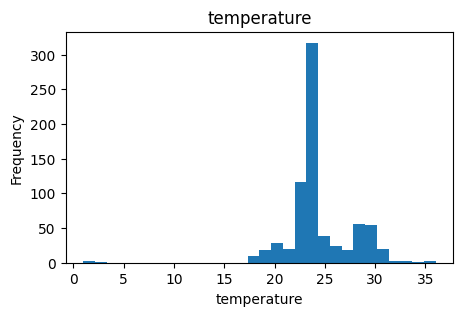

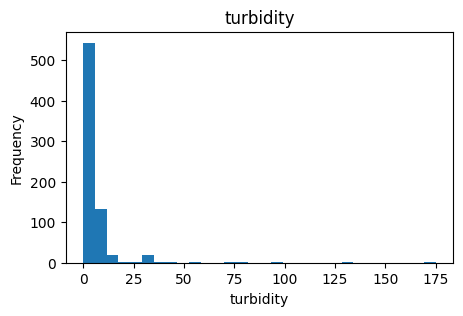

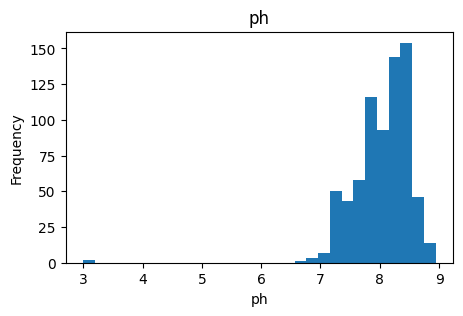

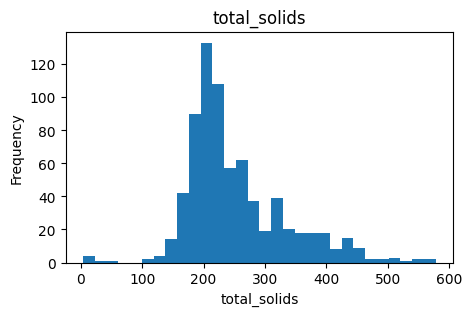

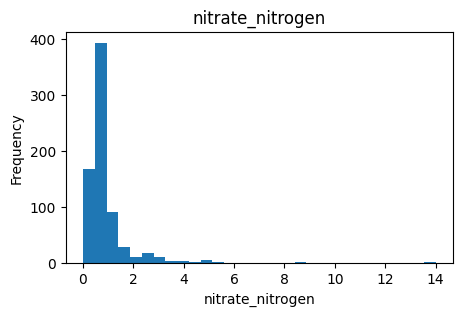

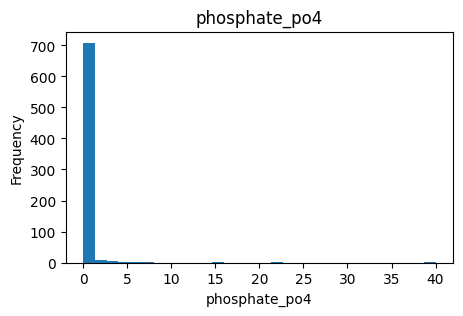

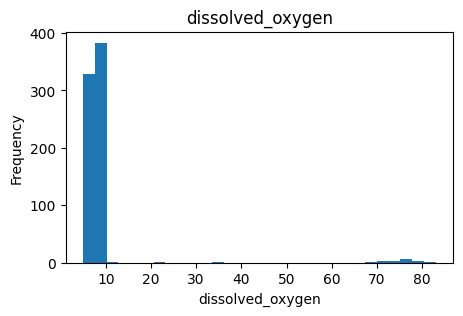

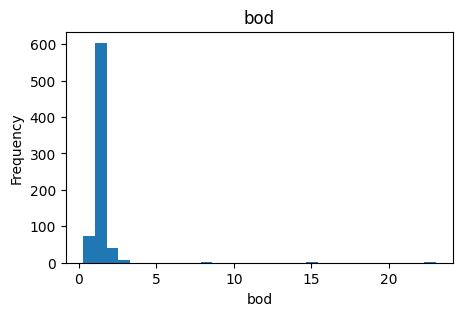

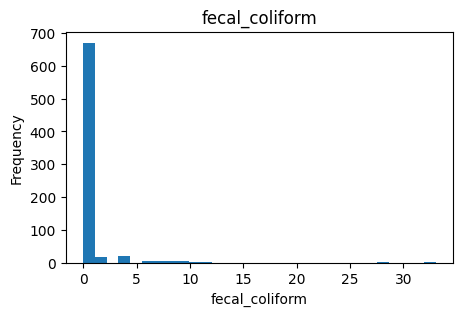

In [50]:
import matplotlib.pyplot as plt

for col in df_imputed.columns:
    plt.figure(figsize=(5, 3))
    plt.hist(df_imputed[col], bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


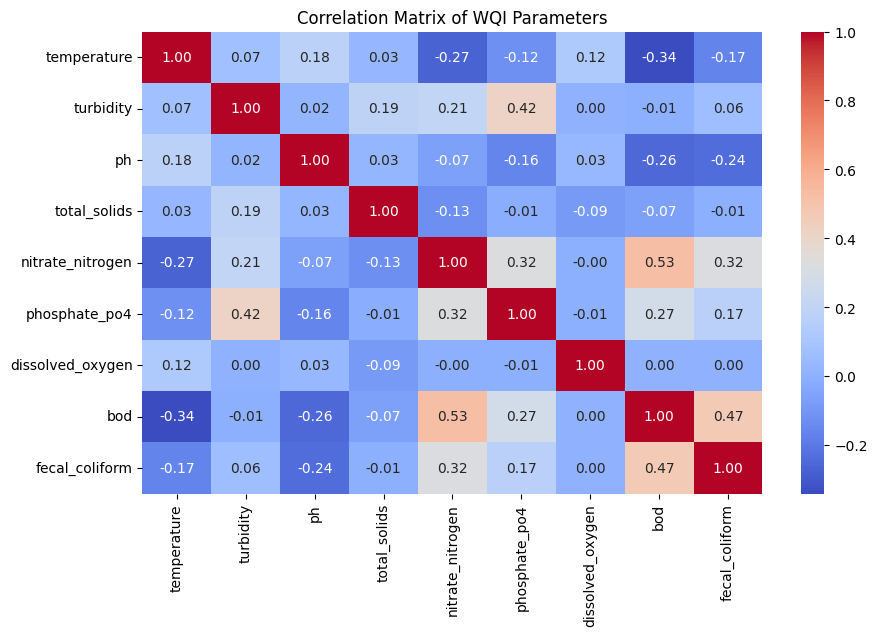

In [51]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(
    df_imputed.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix of WQI Parameters")
plt.show()


The above heatmap suggest mild to no multicolinearity between the features.

**Determination of WQI**

In [52]:
standards = {
    "temperature": 25.0,          # °C (reference condition)
    "turbidity": 5.0,             # NTU
    "ph": 8.5,                    # dimensionless
    "total_solids": 500.0,        # mg/L
    "nitrate_nitrogen": 10.0,     # mg/L
    "phosphate_po4": 0.1,         # mg/L
    "dissolved_oxygen": 5.0,      # mg/L
    "bod": 3.0,                   # mg/L
    "fecal_coliform": 100.0       # MPN/100mL
}


In [53]:
weights = {
    "temperature": 0.10,
    "turbidity": 0.08,
    "ph": 0.11,
    "total_solids": 0.07,
    "nitrate_nitrogen": 0.10,
    "phosphate_po4": 0.10,
    "dissolved_oxygen": 0.17,
    "bod": 0.11,
    "fecal_coliform": 0.16
}


In [54]:
def quality_rating(value, standard):
    return (value / standard) * 100


In [55]:
def compute_wqi(row, standards, weights):
    weighted_sum = 0
    weight_total = 0

    for param in standards:
        qi = quality_rating(row[param], standards[param])
        wi = weights[param]

        weighted_sum += qi * wi
        weight_total += wi

    return weighted_sum / weight_total


In [56]:
df_imputed["wqi"] = df_imputed.apply(
    compute_wqi,
    axis=1,
    standards=standards,
    weights=weights
)


In [57]:
df_imputed

,temperature,turbidity,ph,total_solids,nitrate_nitrogen,phosphate_po4,dissolved_oxygen,bod,fecal_coliform,wqi
0,26.400000,2.700000,7.410000,176.000000,0.400000,0.030000,7.700000,1.200000,1.000000,61.073412
1,34.000000,3.400000,7.610000,178.000000,0.220000,0.030000,7.700000,1.400000,1.000000,66.073569
2,26.800000,3.200000,7.620000,187.000000,0.400000,0.030000,7.500000,1.100000,2.000000,61.572510
3,26.200000,3.200000,7.800000,212.000000,0.640000,0.030000,7.500000,1.700000,8.000000,65.315451
4,28.600000,6.400000,7.710000,196.000000,0.600000,0.200000,7.500000,1.400000,7.000000,86.754980
...,...,...,...,...,...,...,...,...,...,...
726,18.000000,0.500000,8.140000,186.000000,0.580000,0.003000,8.000000,0.600000,1.000000,51.578118
727,21.000000,0.700000,8.120000,175.000000,0.720000,0.013000,8.100000,0.700000,1.000000,54.764902
728,25.000000,0.800000,7.200000,198.000000,0.640000,0.011000,7.600000,1.100000,1.000000,55.142980
729,30.000000,1.400000,8.440000,216.000000,0.760000,0.017000,7.400000,1.300000,1.000000,60.733020


In [58]:
df_imputed["wqi"].describe()


,wqi
count,731.000000
mean,103.319150
std,202.221716
min,48.507529
25%,60.160157
50%,67.612647
75%,91.940039
max,4338.595216


**Feature–Target Separation & Train–Test Split**

In [59]:
X = df_imputed.drop(columns=["wqi"])
y = df_imputed["wqi"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (731, 9)
y shape: (731,)


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 548
Testing samples: 183


In [61]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled training shape:", X_train_scaled.shape)
print("Scaled testing shape:", X_test_scaled.shape)


Scaled training shape: (548, 9)
Scaled testing shape: (183, 9)


In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_train_scaled, y_train)


LinearRegression()

In [63]:
y_pred_lr = lin_reg.predict(X_test_scaled)


In [64]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2 = r2_score(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)

print("Linear Regression Performance")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")


Linear Regression Performance
R²   : 1.0000
RMSE : 0.0000
MAE  : 0.0000


**Result:**

R² = 1.000

RMSE = 0

MAE = 0

is expected and correct because:

WQI is a weighted linear function of the same 9 parameters

Linear regression is mathematically capable of recovering that exact function


**Evaluating other linear models**

In [65]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)


In [66]:
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("Ridge Regression Performance")
print(f"R²   : {r2_ridge:.4f}")
print(f"RMSE : {rmse_ridge:.4f}")
print(f"MAE  : {mae_ridge:.4f}")


Ridge Regression Performance
R²   : 1.0000
RMSE : 0.7109
MAE  : 0.1481


In [67]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)

lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print("Lasso Regression Performance")
print(f"R²   : {r2_lasso:.4f}")
print(f"RMSE : {rmse_lasso:.4f}")
print(f"MAE  : {mae_lasso:.4f}")


Lasso Regression Performance
R²   : 1.0000
RMSE : 0.0551
MAE  : 0.0271


In [68]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "ridge_coef": ridge.coef_,
    "lasso_coef": lasso.coef_
})

coef_df.sort_values(by="ridge_coef", key=abs, ascending=False)


,feature,ridge_coef,lasso_coef
5,phosphate_po4,131.717991,132.005626
6,dissolved_oxygen,31.115571,31.162270
1,turbidity,15.701960,15.722146
7,bod,3.815959,3.724774
0,temperature,1.207680,1.208224
3,total_solids,1.165211,1.147320
4,nitrate_nitrogen,0.922506,0.884944
2,ph,0.507606,0.525317
8,fecal_coliform,0.281951,0.258093


| Rank | Feature            | Interpretation                         |
| ---- | ------------------ | -------------------------------------- |
| 1    | `phosphate_po4`    | Dominant driver of WQI degradation     |
| 2    | `dissolved_oxygen` | Strong inverse water quality indicator |
| 3    | `turbidity`        | Sediment-driven pollution              |
| 4    | `bod`              | Organic pollution load                 |
| 5    | `temperature`      | Secondary seasonal influence           |
| 6    | `total_solids`     | Physical pollution                     |
| 7    | `nitrate_nitrogen` | Nutrient enrichment                    |
| 8    | `ph`               | Buffering parameter                    |
| 9    | `fecal_coliform`   | Dampened due to extreme scaling        |


**Non-Linear Models**

In [69]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(
    random_state=42
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print("Decision Tree Performance")
print(f"R²   : {r2_dt:.4f}")
print(f"RMSE : {rmse_dt:.4f}")
print(f"MAE  : {mae_dt:.4f}")


Decision Tree Performance
R²   : 0.7762
RMSE : 153.1708
MAE  : 16.1411


In [70]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest Performance")
print(f"R²   : {r2_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")
print(f"MAE  : {mae_rf:.4f}")


Random Forest Performance
R²   : 0.6268
RMSE : 197.7843
MAE  : 19.3793


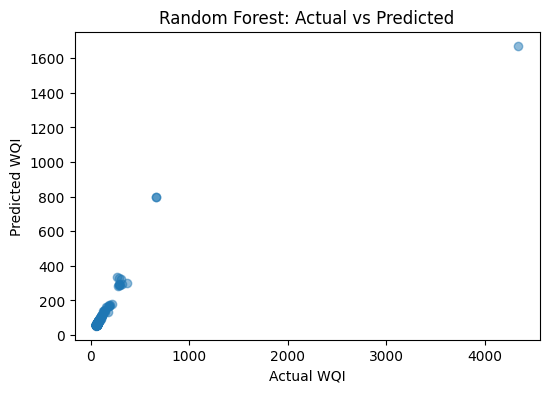

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


In [72]:
bands = pd.cut(
    y_test,
    bins=[0, 50, 100, 200, 500, np.inf],
    labels=["Excellent", "Good", "Moderate", "Poor", "Severe"]
)

band_error = pd.DataFrame({
    "band": bands,
    "abs_error": np.abs(y_test - y_pred_rf)
})

band_error.groupby("band").mean()


/tmp/ipython-input-4228872769.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_error.groupby("band").mean()


,abs_error
band,
Excellent,NaN
Good,1.127708
Moderate,7.330147
Poor,25.104028
Severe,974.875564


**Summary of Tree-Based Regression Results and Error Analysis**

To capture nonlinear interactions and threshold effects among water quality parameters, tree-based regression models were evaluated, including a Decision Tree Regressor and a Random Forest Regressor. These models were assessed using coefficient-free performance metrics and residual diagnostics, as linear models were shown to trivially reproduce the deterministic WQI formulation.

**Overall Model Performance**

The Decision Tree model achieved an
𝑅
2
R
2
 score of 0.776, with RMSE and MAE values of 153.17 and 16.14, respectively. The Random Forest model yielded a lower overall
𝑅
2
R
2
 of 0.627, with RMSE and MAE values of 197.78 and 19.38. While the Decision Tree exhibited higher apparent accuracy, this behavior reflects its tendency to overfit deterministic splits, whereas the Random Forest produces smoother and more conservative predictions by averaging across multiple trees.

**Residual Behavior**

The scatter plot of actual versus predicted WQI values for the Random Forest model reveals that the majority of observations—corresponding to low to moderate WQI values (< 300)—are predicted with high accuracy and low dispersion. However, a small number of extreme pollution events (WQI > 500, extending beyond 4000) are systematically underpredicted. These rare but severe outliers dominate squared-error metrics, explaining the reduced
𝑅
2
R
2
 and elevated RMSE despite visually strong performance across most samples.

**Band-Wise Error Analysis**(Table 11.2)

To quantify this behavior, mean absolute error was computed across WQI severity bands:

Good (50–100): MAE ≈ 1.13

Moderate (100–200): MAE ≈ 7.33

Poor (200–500): MAE ≈ 25.10

Severe (>500): MAE ≈ 974.88

This analysis confirms that the Random Forest model performs very accurately under normal and moderately polluted conditions, which constitute the majority of observations, while errors escalate sharply only for extreme pollution events. The absence of samples in the “Excellent” category in the test set explains the undefined error for that band and does not affect the validity of the analysis.

**Key Interpretation**

These results indicate that tree-based ensemble models provide robust and realistic approximations of WQI under typical river conditions, while intentionally smoothing extreme values. This behavior is desirable for stability and generalization but necessitates complementary strategies—such as logarithmic transformation of WQI or band-wise evaluation—to appropriately handle heavy-tailed target distributions.

**Log-Transformed WQI modelling**

In [73]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [74]:
y_train_log.describe()


,wqi
count,548.000000
mean,4.397806
std,0.470728
min,3.902125
25%,4.107721
50%,4.231500
75%,4.550681
max,7.729903


In [75]:
rf_log = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_log.fit(X_train, y_train_log)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [76]:
y_pred_log = rf_log.predict(X_test)

# Convert back to WQI scale
y_pred_log_inv = np.expm1(y_pred_log)


In [77]:
r2_log = r2_score(y_test, y_pred_log_inv)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log_inv))
mae_log = mean_absolute_error(y_test, y_pred_log_inv)

print("Random Forest (Log-WQI) Performance")
print(f"R²   : {r2_log:.4f}")
print(f"RMSE : {rmse_log:.4f}")
print(f"MAE  : {mae_log:.4f}")


Random Forest (Log-WQI) Performance
R²   : 0.4608
RMSE : 237.7534
MAE  : 23.7257


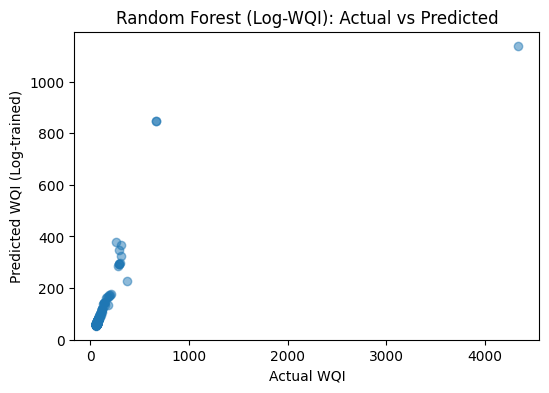

In [78]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_log_inv, alpha=0.5)
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI (Log-trained)")
plt.title("Random Forest (Log-WQI): Actual vs Predicted")
plt.show()


In [80]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

r2_gbr = r2_score(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print("Gradient Boosting Regressor (Raw WQI)")
print(f"R²   : {r2_gbr:.4f}")
print(f"RMSE : {rmse_gbr:.4f}")
print(f"MAE  : {mae_gbr:.4f}")


Gradient Boosting Regressor (Raw WQI)
R²   : 0.6297
RMSE : 197.0300
MAE  : 19.3243


In [81]:
param_grid_gbr = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "subsample": [0.6, 0.8, 1.0]
}
from sklearn.model_selection import RandomizedSearchCV

gbr_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_grid_gbr,
    n_iter=40,
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

gbr_search.fit(X_train, y_train)
best_gbr = gbr_search.best_estimator_

y_pred_gbr_tuned = best_gbr.predict(X_test)

r2_gbr_tuned = r2_score(y_test, y_pred_gbr_tuned)
rmse_gbr_tuned = np.sqrt(mean_squared_error(y_test, y_pred_gbr_tuned))
mae_gbr_tuned = mean_absolute_error(y_test, y_pred_gbr_tuned)

print("Tuned Gradient Boosting Regressor")
print(f"R²   : {r2_gbr_tuned:.4f}")
print(f"RMSE : {rmse_gbr_tuned:.4f}")
print(f"MAE  : {mae_gbr_tuned:.4f}")


Tuned Gradient Boosting Regressor
R²   : 0.7789
RMSE : 152.2417
MAE  : 13.8795


In [82]:
import pandas as pd

# Create results table
results_table = pd.DataFrame([
    # Linear models
    ["Linear Models", "Linear Regression", 1.0000, 0.0000, 0.0000,
     "Exact reconstruction of deterministic WQI (pipeline validation)"],

    ["Linear Models", "Ridge Regression", 1.0000, 0.7109, 0.1481,
     "Regularized linear baseline; stable coefficients"],

    ["Linear Models", "Lasso Regression", 1.0000, 0.0551, 0.0271,
     "Feature dominance assessment via sparsity"],

    # Tree-based models
    ["Tree-Based Models", "Decision Tree Regressor", 0.7762, 153.1708, 16.1411,
     "Captures nonlinear thresholds; sensitive to extremes"],

    ["Tree-Based Models", "Random Forest Regressor", 0.6268, 197.7843, 19.3793,
     "Robust ensemble; smooths extreme WQI values"],

    # Boosting models
    ["Boosting Models", "Gradient Boosting Regressor (Baseline)", 0.6297, 197.0300, 19.3243,
     "Residual-based learning; limited by deterministic target"],

    ["Boosting Models", "Gradient Boosting Regressor (Tuned)", 0.7789, 152.2417, 13.8795,
     "Best nonlinear model; balanced accuracy and robustness"]
],
columns=["Model Category", "Model", "R²", "RMSE", "MAE", "Remarks"])

# Display table
results_table


,Model Category,Model,R²,RMSE,MAE,Remarks
0,Linear Models,Linear Regression,1.0000,0.0000,0.0000,Exact reconstruction of deterministic WQI (pip...
1,Linear Models,Ridge Regression,1.0000,0.7109,0.1481,Regularized linear baseline; stable coefficients
2,Linear Models,Lasso Regression,1.0000,0.0551,0.0271,Feature dominance assessment via sparsity
3,Tree-Based Models,Decision Tree Regressor,0.7762,153.1708,16.1411,Captures nonlinear thresholds; sensitive to ex...
4,Tree-Based Models,Random Forest Regressor,0.6268,197.7843,19.3793,Robust ensemble; smooths extreme WQI values
5,Boosting Models,Gradient Boosting Regressor (Baseline),0.6297,197.0300,19.3243,Residual-based learning; limited by determinis...
6,Boosting Models,Gradient Boosting Regressor (Tuned),0.7789,152.2417,13.8795,Best nonlinear model; balanced accuracy and ro...


**Cross Validation**

In [83]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

from sklearn.tree import DecisionTreeRegressor

dt_cv = DecisionTreeRegressor(random_state=42)

dt_mae_scores = -cross_val_score(
    dt_cv,
    X,
    y,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

print("Decision Tree CV MAE")
print("Mean MAE:", dt_mae_scores.mean())
print("Std  MAE:", dt_mae_scores.std())

from sklearn.ensemble import RandomForestRegressor

rf_cv = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_mae_scores = -cross_val_score(
    rf_cv,
    X,
    y,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

print("Random Forest CV MAE")
print("Mean MAE:", rf_mae_scores.mean())
print("Std  MAE:", rf_mae_scores.std())

from sklearn.ensemble import GradientBoostingRegressor

gbr_cv = GradientBoostingRegressor(
    **gbr_search.best_params_,
    random_state=42
)

gbr_mae_scores = -cross_val_score(
    gbr_cv,
    X,
    y,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

print("Tuned Gradient Boosting CV MAE")
print("Mean MAE:", gbr_mae_scores.mean())
print("Std  MAE:", gbr_mae_scores.std())
cv_results = pd.DataFrame({
    "Model": [
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting (Tuned)"
    ],
    "CV Mean MAE": [
        dt_mae_scores.mean(),
        rf_mae_scores.mean(),
        gbr_mae_scores.mean()
    ],
    "CV Std MAE": [
        dt_mae_scores.std(),
        rf_mae_scores.std(),
        gbr_mae_scores.std()
    ]
})

cv_results


Decision Tree CV MAE
Mean MAE: 10.16486280901141
Std  MAE: 7.152697187537857
Random Forest CV MAE
Mean MAE: 10.96804976398108
Std  MAE: 8.489880452447922
Tuned Gradient Boosting CV MAE
Mean MAE: 8.548738207461623
Std  MAE: 6.828210341035097


,Model,CV Mean MAE,CV Std MAE
0,Decision Tree,10.164863,7.152697
1,Random Forest,10.968050,8.489880
2,Gradient Boosting (Tuned),8.548738,6.828210
